In [5]:
cd /content/drive/MyDrive/Colab Notebooks/VAE

/content/drive/MyDrive/Colab Notebooks/VAE


In [6]:
filename = ''

In [7]:
pip install tensorboardX

     |████████████████████████████████| 317kB 22.0MB/s 


In [8]:
import torch
from torch import nn, optim  
from torch.nn import functional as F
import pandas as pd
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import Logger
from IPython import display

In [9]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/datasets", train=True, transform=transform, download=True
) 

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
n_features = 28*28
img_size = 28
distrib_features = 16

In [11]:
logger = Logger(model_name='VAE_DC', data_name='MNIST')

In [12]:
n_filter = 64

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(len(x), self.shape[0], self.shape[1])

class DCVAutoEncoder(nn.Module):
  def __init__(self):
    super(DCVAutoEncoder, self).__init__() 
    self.encoder = nn.Sequential(  
        nn.Conv2d(1, 128, 3, 1, padding_mode='reflect'),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 64, 3, 2, padding_mode='reflect'),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2), 

        nn.Conv2d(64, 32, 3, 2, padding_mode='reflect'), 
        nn.LeakyReLU(0.2), 
        nn.Flatten(),
    
        nn.Linear(128, distrib_features*2), 
        nn.LeakyReLU(0.2) 
        #nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1, 32, 5, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),

        nn.ConvTranspose2d(32, 64, 5, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(64, 128, 5, 2),
        nn.MaxPool2d(2),
        nn.Dropout(0.3),
        nn.LeakyReLU(0.2),
        nn.Flatten(),


        nn.Linear(in_features=10368, out_features=1026),  
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=1026, out_features=n_features),  
        nn.LeakyReLU(0.2)
        #nn.ReLU(),
    )
    
    # Network to learn mu
    self.mu_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )

    # Network to learn log_var
    self.logvar_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        #nn.ReLU()
    )
  
  def reparametization(self, mean, log_var):
    std = torch.exp(log_var/2)  # the standard deviation
    eps = torch.randn_like(std) # sample epsilone from N(0,1) with the same size as std
    z = mean + (eps * std) # Sample example similar to the input space
    return z  

  def forward(self, x):
    x = self.encoder(vector_to_image(x))
    #x = F.relu(x)
    #x = x.view(-1, 2, distrib_features)

    mu = F.relu(self.mu_network(x)) #x[:, 0, :] # first feature is used as mean
    l_var = F.relu(self.logvar_network(x)) #x[:, 1, :] # the order features are used as variances  

    z = self.reparametization(mu, l_var)

    x = F.relu(z) 
    #print("here i X", x.size())
    x = self.decoder(x.view(x.shape[0], 1, 4, 4))
    reconstructed = torch.sigmoid(x)
    return reconstructed, mu, l_var # return all learned parameters

In [13]:
input = torch.randn(32, 1, 4, 4)
print(input.size())
m = nn.Sequential( 
nn.ConvTranspose2d(1, 32, 5, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),

        nn.ConvTranspose2d(32, 64, 5, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(64, 128, 5, 2),
        nn.MaxPool2d(2),
        nn.Dropout(0.3),
        nn.LeakyReLU(0.2),
        nn.Flatten(),


        nn.Linear(in_features=10368, out_features=1026),  
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=1026, out_features=n_features),  
        nn.LeakyReLU(0.2)
)
print(m)
output = m(input)
print(output.size())

torch.Size([32, 1, 4, 4])
Sequential(
  (0): ConvTranspose2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): ConvTranspose2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2)
  (7): ConvTranspose2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.3, inplace=False)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=10368, out_features=1026, bias=True)
  (13): LeakyReLU(negative_slope=0.2)
  (14): Linear(in_features=1026, out_features=784, bias=True)
  (15): LeakyReLU(negative_slope=0.2)
)
torch.Size([32, 784])


In [14]:
def vector_to_image(image):
  return image.view(image.shape[0], 1, 28, 28)

In [15]:
has_gpu = torch.cuda.is_available() 
# batch size
batch_size = 100

autoencoder = DCVAutoEncoder()

In [16]:
if has_gpu:
  autoencoder = autoencoder.cuda()
else:
  autoencoder = autoencoder

print(autoencoder)

DCVAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding_mode=reflect)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding_mode=reflect)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=128, out_features=32, bias=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [14]:
def vea_loss(bce_loss, mean, log_var):
  # sum bce loss and the KL divergence
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return bce_loss + KLD

In [15]:
ae_optim = optim.Adam(autoencoder.parameters(), lr=0.001)

# loss function
loss = nn.BCELoss(reduction='sum')

# Number of epochs
num_epochs = 1000


In [16]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

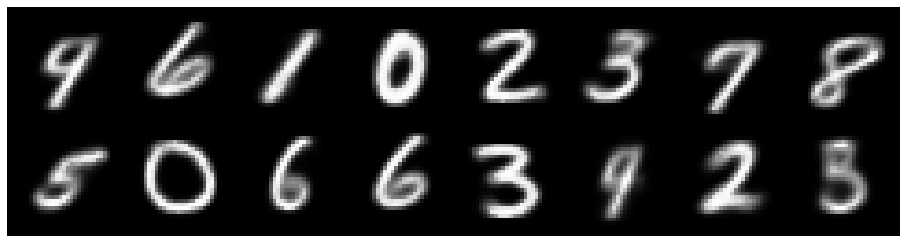

epoch : 801/1000, loss = 91726.652832
epoch : 802/1000, loss = 91742.332397
epoch : 803/1000, loss = 91812.850688
epoch : 804/1000, loss = 91837.198120
epoch : 805/1000, loss = 91720.214101
epoch : 806/1000, loss = 91841.372121
epoch : 807/1000, loss = 91754.293518
epoch : 808/1000, loss = 91803.663686
epoch : 809/1000, loss = 91754.377767
epoch : 810/1000, loss = 91836.045736
epoch : 811/1000, loss = 91827.189555
epoch : 812/1000, loss = 91778.022705
epoch : 813/1000, loss = 91720.320048
epoch : 814/1000, loss = 91834.205037
epoch : 815/1000, loss = 91910.061157
epoch : 816/1000, loss = 91899.155334
epoch : 817/1000, loss = 91734.410075
epoch : 818/1000, loss = 91754.570709
epoch : 819/1000, loss = 91883.446004
epoch : 820/1000, loss = 91810.654622
epoch : 821/1000, loss = 91815.814585
epoch : 822/1000, loss = 91872.823527
epoch : 823/1000, loss = 91804.677673
epoch : 824/1000, loss = 91773.764669
epoch : 825/1000, loss = 91745.022654
epoch : 826/1000, loss = 91789.915771
epoch : 827/

In [17]:
for epoch in range(num_epochs): # loop over dataset
    loss_log = 0  
    for n_batch, (train_data, _) in enumerate(data_loader):  

        
        train_data  = Variable(train_data.view(-1, n_features))
        #print(train_data.view(-1, n_features).size())

        if has_gpu: train_data = train_data.cuda()

        # reset the gradients back to zero
        ae_optim.zero_grad()

        # compute reconstruction 
    
        reconstructed, mu, log_var = autoencoder(train_data)

        # compute the loss 
        bce_loss = loss(reconstructed, train_data)  

        train_loss = vea_loss(bce_loss, mu, log_var)

        # backpropagate the gradient 
        train_loss.backward()

        # update parameter update based on current gradients
        ae_optim.step()
        loss_log += train_loss.item()
    
    # Log the image
    if(epoch) % 200 == 0:
        display.clear_output(True)
        logger.log_images(images = vector_to_image(reconstructed[0:16]).data.cpu(), num_images = 16, epoch=epoch, n_batch = n_batch,  num_batches=batch_size)
        logger.save_model(autoencoder, epoch)
    # epoch loss 
    loss_log = loss_log / len(train_data)

    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss_log))

In [1]:
def plot_images(model,
                image,
                show=True,
                step=0,
                model_name="auto_encoder"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        model (Models): 
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """

    constructed, _, _ = model(image)
    images = constructed.cpu().detach()
    print(model_name,
          "Labels for generated images: ")
    print("image size", images.shape)
    plt.figure(figsize=(12, 12))
    num_images = images.shape[0]
    image_size = 28
    
    rows =  int(np.sqrt(num_images))*2  #int(math.sqrt(noise_class.shape[0]))
    print("ROWS", rows)
    for i in range(num_images): 
        plt.subplot(rows, rows, i + 1)
        img2 = np.reshape(image[i].cpu().detach(), [image_size, image_size]) 
        plt.imshow(img2, cmap='gray')
        plt.axis('off')

        plt.subplot(rows, rows, num_images + i + 1)
        img = np.reshape(images[i], [image_size, image_size])  
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
    save_images(plt)
    if show:
        plt.show()
    else:
        plt.close('all')

In [2]:
data_subdir = 'mnist'
def make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
          print(e)
        #    if e.errno != errno.EEXIST:
        #       raise

def save_images(fig, epoch=0, n_batch=0, comment=''):
        out_dir = './data/images/{}'.format(data_subdir)
        make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir, comment, epoch, n_batch))

In [ ]:
img = Variable(train_data[16:32].view(-1, n_features)) #Variable(train_dataset.train_data[0].view(-1, n_features)).cuda()

img = img.cuda()

#img = torch.randn(train_data[0:16]).cuda()

print(img.shape)
plot_images(autoencoder, img)

torch.Size([16, 1, 28, 28])
auto_encoder Labels for generated images: 
image size torch.Size([16, 784])
ROWS 8
[Errno 17] File exists: './data/images/mnist'


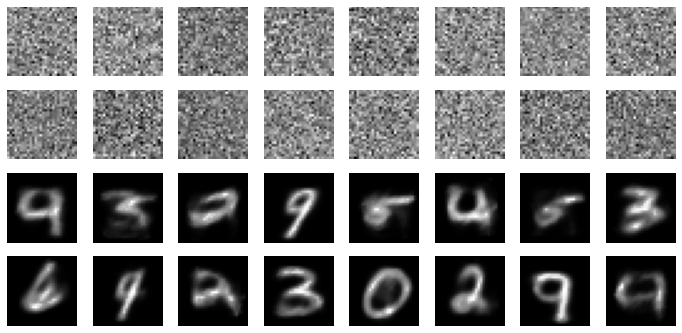

In [37]:
autoencoder.load_state_dict(torch.load("./data/models/VAE_DC/MNIST/D_epoch_800"))
img = torch.randn(16, 1, 28, 28).cuda()

print(img.shape)
plot_images(autoencoder, img)